# Lecture: Complex Network Analysis

Prof. Dr. Michael Gertz

Winter Semester 2021/22

## Assignment 3 - Random Graph Models and Statistical Characterizations

Students: Felix Hausberger, Nils Krehl, Patrick Günther

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from igraph import *
import numpy as np

In [2]:
data = pd.read_csv("FAOSTAT_data.csv")

In [3]:
data.head()

,Domain Code,Domain,Reporter Country Code (FAO),Reporter Countries,Partner Country Code (FAO),Partner Countries,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FT,Forestry Trade Flows,2,Afghanistan,68,France,5922,Export Value,1633,"Sawnwood, non-coniferous all",2017,2017,1000 US$,37,NaN,Official data
1,FT,Forestry Trade Flows,2,Afghanistan,165,Pakistan,5922,Export Value,1671,Newsprint,2017,2017,1000 US$,2,NaN,Official data
2,FT,Forestry Trade Flows,3,Albania,11,Austria,5922,Export Value,1633,"Sawnwood, non-coniferous all",2017,2017,1000 US$,29,NaN,Official data
3,FT,Forestry Trade Flows,3,Albania,33,Canada,5922,Export Value,1619,Wood chips and particles,2017,2017,1000 US$,0,NaN,Official data
4,FT,Forestry Trade Flows,3,Albania,68,France,5922,Export Value,1632,"Sawnwood, coniferous",2017,2017,1000 US$,13,NaN,Official data


In [4]:
# remove non-empty values in Flag column
data = data[data["Flag"].isna()]

assert "Total FAO" not in data["Partner Countries"]
assert "Others (adjustment)" not in data["Partner Countries"]

In [5]:
# is the unit the same?
data["Unit"].unique()

array(['1000 US$'], dtype=object)

# 1. 

Based on G, extract $G_{France}$ , an undirected, unweighted, induced subgraph for France and its neighbors, also called an ego graph, and fill out the values listed in the following table ($N, L, L_{min}, L_{max}, k_{min}, k_{max}$) for $G_{France}$. Ignore edge weights and directionality as we are interested in structural properties only.

In [6]:
def create_export_graph(graph_df):
    G_2017 = Graph(directed=True)

    # create nodes
    countries = graph_df["Reporter Countries"].tolist() + graph_df["Partner Countries"].tolist()
    countries = set(countries)
    G_2017.add_vertices(countries)
    G_2017.vs['label'] = list(countries)
    countries_dict = {}
    for i, c in enumerate(countries):
        countries_dict[c] = i

    # create vertices
    edges = []
    weights = []
    for _, row in graph_df.iterrows():
        edges.append((countries_dict[row["Reporter Countries"]], countries_dict[row["Partner Countries"]]))
        weights.append(row["Value"])

    G_2017.add_edges(edges)
    #G_2017.es['weight'] = weights
    G_2017.es['label'] = weights
    
    return G_2017

In [7]:
selected_countries_1 = data[data["Reporter Countries"] == "France"]["Partner Countries"].tolist()
selected_countries_2 = data[data["Partner Countries"] == "France"]["Reporter Countries"].tolist()
selected_countries = set(selected_countries_1 + selected_countries_2)
selected_countries.add("France")
print(selected_countries)
print("France" in selected_countries)

small_data = data[data["Reporter Countries"].isin(selected_countries)]
small_data = small_data[small_data["Partner Countries"].isin(selected_countries)]

graph_df = small_data[["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum().reset_index()
G_2017 = create_export_graph(graph_df)

{'Indonesia', 'Saudi Arabia', 'Kenya', 'Liberia', 'United Republic of Tanzania', 'Ecuador', 'Bolivia (Plurinational State of)', 'Malta', 'Estonia', 'Cyprus', 'Cameroon', 'France', 'Djibouti', 'Austria', 'South Africa', "Côte d'Ivoire", 'Tunisia', 'Colombia', 'Thailand', 'Togo', 'Ireland', 'Belgium', 'Pakistan', 'Senegal', 'Australia', 'Mauritania', 'Chad', 'Uruguay', 'Finland', 'Russian Federation', 'Denmark', 'Dominican Republic', 'Japan', 'China', 'Romania', 'Nigeria', 'Norway', 'Mozambique', 'Mali', 'Georgia', 'Guatemala', 'Latvia', 'Croatia', 'Guinea', 'Portugal', 'Turkey', 'Slovenia', 'Germany', 'Morocco', 'Afghanistan', 'Haiti', 'Sri Lanka', 'Mexico', 'Singapore', 'Iceland', 'United States of America', 'Greece', 'Poland', 'Italy', 'Guyana', 'Canada', 'Albania', 'Argentina', 'Lithuania', 'Oman', 'Belarus', 'Chile', 'Switzerland', 'Gabon', 'Peru', 'Paraguay', 'Kuwait', 'Iraq', 'Spain', 'Qatar', 'Congo', 'Suriname', 'Ukraine', 'Jordan', 'Republic of Korea', 'Somalia', 'Syrian Arab R

In [8]:
visual_style = {}

out_name = "graph_1.png"

visual_style["bbox"] = (600,400)
visual_style["margin"] = 10
visual_style["vertex_color"] = 'white'
visual_style["vertex_size"] = 20
visual_style["vertex_label_size"] = 5
visual_style["edge_label_size"] = 0
visual_style["edge_curved"] = True
my_layout = G_2017.layout_lgl()
visual_style["layout"] = my_layout
plot(G_2017, out_name, **visual_style)

looks pretty bad, so we decided to use networkx for visualization...

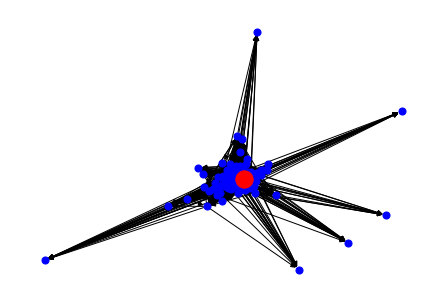

In [9]:
G_2017.vs['label']
nodes_dict = {}
for n in range(len(G_2017.vs['label'])):
    nodes_dict[n] = G_2017.vs['label'][n]
reversed_nodes_dict = dict(map(reversed, nodes_dict.items()))
G_2017_nx = G_2017.to_networkx()

node_id_france = reversed_nodes_dict["France"]
ego_graph_france = nx.ego_graph(G_2017_nx, node_id_france)

# Draw graph
pos = nx.spring_layout(ego_graph_france)#, seed=20532)  # Seed layout for reproducibility
nx.draw(ego_graph_france, pos, node_color="b", node_size=50, with_labels=False)
# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(ego_graph_france, pos, nodelist=[node_id_france], **options)
plt.show()

In [10]:
N = G_2017_nx.number_of_nodes()
print("N = {}".format(N))
L = G_2017_nx.number_of_edges()
print("L = {}".format(L))

print("L_min = {} (the minimal number of links is (N-1), as all nodes in the induced subgraph at least need to have an edge to France)".format(N-1))
print("L_max = (N * (N-1) / 2) = {} (the maximal number of links is reached only by a complete graph)".format((N*(N-1))/2))

node_degrees = list(G_2017_nx.degree())
nodes, degrees = zip(*node_degrees)
index_min = np.argmin(degrees)
index_max = np.argmax(degrees)
print("k_min = {}".format(degrees[index_min]))
print("k_max = {}".format(degrees[index_max]))

N = 122
L = 4702
L_min = 121 (the minimal number of links is (N-1), as all nodes in the induced subgraph at least need to have an edge to France)
L_max = (N * (N-1) / 2) = 7381.0 (the maximal number of links is reached only by a complete graph)
k_min = 4
k_max = 210


## 2.

Next, programatically calculate the following random graph metrics for $G_{France}$ , a real world network. Use the values from above and Python as necessary.

In [11]:
average_k = (np.sum(degrees)) / N
print("<k> = {}".format(average_k))

<k> = 77.08196721311475


In [12]:
p = average_k / (N-1)
print("p = {}".format(p))

p = 0.6370410513480558


In [13]:
average_L = (p * N * (N-1)) / 2
print("<L> = {}".format(average_L))

<L> = 4701.999999999999


In [14]:
average_k_2 = (2 * average_L) / N
print("<k> = {}".format(average_k_2))

<k> = 77.08196721311474


In [15]:
p_2 = (2 * average_L) / (N * (N-1))
print("p = {}".format(p_2))

p = 0.6370410513480557


In [16]:
average_clustering_coefficient = nx.average_clustering(G_2017_nx)
print("<C> = {}".format(average_clustering_coefficient))

<C> = 0.6750556177167188


## 3.

Based on $N$ and $p$ as calculated previously for $G_{France}$, generate one Erdös-Renyì graph realization $G$ random of the $G(N,p)$ ensemble using your library of choice. Visualize the adjacency matrices $A_{France}$ and $A_{random}$ as shown in Figure 1. What visual differences do you notice between both adjacency matrices? Be precise. Also, explain why these differences might be occurring and how they affect degree distribution and clustering.

In [17]:
A_France = nx.adjacency_matrix(ego_graph_france)

In [18]:
random_graph = nx.erdos_renyi_graph(N, p)
random_graph_adjacency_matrix = nx.adjacency_matrix(random_graph)

In [19]:
node_degrees_random = list(random_graph.degree())
nodes_random, degrees_random = zip(*node_degrees_random)

average_k_random = (np.sum(degrees_random)) / N
print("Random graph <k> = {}".format(average_k_random))

average_clustering_coefficient_random = nx.average_clustering(random_graph)
print("Random graph <C> = {}".format(average_clustering_coefficient_random))

L = random_graph.number_of_edges()
print("Random graph L = {}".format(L))

Random graph <k> = 76.81967213114754
Random graph <C> = 0.6345873233275034
Random graph L = 4686


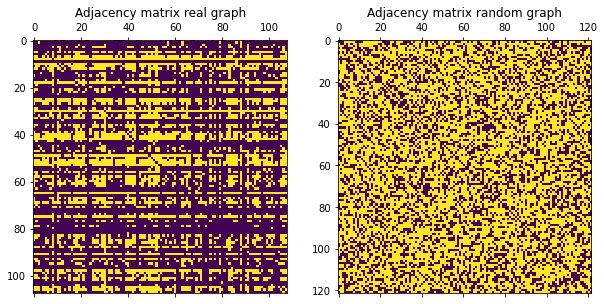

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.set_title("Adjacency matrix real graph")
ax1.matshow(A_France.toarray())
ax2.set_title("Adjacency matrix random graph")
ax2.matshow(random_graph_adjacency_matrix.toarray())
plt.show()

### Comment

#### What visual differences do you notice between both adjacency matrices? 

- Purple areas visualize ones (links) and yellow areas visualize zeros (no links). The real graph contains more links compared to the random graph (more purple areas).
- Furthermore in the random graph the links are distributed in a binomial fashion over all nodes such that we can observe an only moderate expansion of the degree distribution. In the real graph there are some clusters, indicating that some nodes (countries) are connected to more nodes than others as being hubs. This e.g. holds for France of course, which leads to one row being completely purple. Other countries on the other hand might have just a few trade connections in this subgraph as some rows are almost completely yellow.

#### Why do these differences occur and how do they affect degree distribution and clustering.

- Why do they occur: The real graph models the reality based on a dataset. Naturally the links per node are not binomially distributed, some countries can have far more trade connections than other countries. Some countries might even have just a very few trade connections. A random graph does model this in such an extend due to its underlying binomial distribution.
- degree distribution: The degree distribution of the random graph systematically underestimates the number of nodes having very high degrees (hubs) as well as the number of nodes having very few degrees. Only the average degree is be similar. (real: $<k>=77.08$; random: $<k>=76.82$)
- clustering coefficient: The clustering coefficient is just slightly higher in the real graph compared to the random graph, probably because of the sole influence of France (real: $<C>=0,68$; random: $<C>=0,63$). In general, the clustering coefficient of real networks is normally far higher compared to random networks. 

## 4.

Create one plot containing a histogram for the node degrees of $G_{France}$, a histogram for the node degrees $G_{random}$ and a normal distribution $N(\mu, \sigma^2)$. Use the node degrees of $G_{random}$ to calculate the mean $\mu$ and standard deviation $\sigma^2$ that parametrize $N$. What visual differences do you notice between both histograms? Point out the differences if any, be precise, and explain why they might be occurring based on the material from the lecture. Answer whether your Erdös-Renyì ensemble realization of $G(n,p)$
provides good approximations of $G_{France}$.

Mean: 76.81967213114754
Standard deviation: 5.5293796430308815


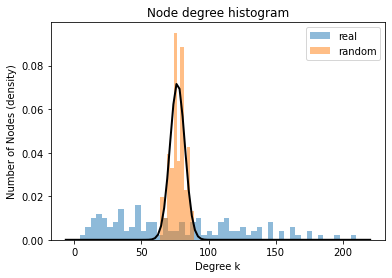

In [21]:
from scipy.stats import norm

# Fit a normal distribution to the data: mean and standard deviation
mu, std = norm.fit(degrees_random)
print("Mean: {}".format(mu))
print("Standard deviation: {}".format(std))

plt.hist(degrees, 50, alpha=0.5, label='real', density=True)
plt.hist(degrees_random, 10, alpha=0.5, label='random', density=True)
plt.legend(loc='upper right')
# Plot the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label="normal distribution")

plt.title("Node degree histogram")
plt.xlabel("Degree k")
plt.ylabel("Number of Nodes (density)")
plt.show()

### Comment

#### What visual differences do you notice between both histograms?

The node degree histogram of the real network is roughly distributed equally over the whole range from 0 to about 200 without having any peaks. The degree distribution of the random network is not distributed equally over the whole range. It follows a normal distribution with mean 76,89 and standard deviation 5,3. The majority of nodes has a node degree around 76.  

#### Point out the differences if any, be precise, and explain why they might be occurring based on the material from the lecture. 

The random graph is generated based on the number of nodes (n) and the link probability (p). The link probability is calculated based on the average degree ($<k>$) of all nodes of the real graph. This generalization to p is not sufficient to model the real graph, because in reality also nodes with lots of links and very few links exist.

#### Answer whether your Erdös-Renyì ensemble realization of $G(n,p)$ provides good approximations of $G_{France}$.

No, the random graph does not provide a good approximation of the real graph, because the degree distribution differs a lot and consequently the whole graph has different properties.